In [1]:
import jax
from jax import numpy as np
from jax import scipy as sp
from jax import random

import numpy as onp
from numpy.polynomial.hermite import hermgauss

import paragami

# GMM libraries
import bnpgmm_runjingdev.gmm_clustering_lib as gmm_lib
import bnpgmm_runjingdev.utils_lib as utils_lib
import bnpgmm_runjingdev.gmm_optimization_lib as gmm_optim_lib
from bnpgmm_runjingdev import gmm_posterior_quantities_lib

# BNP libraries
from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation, get_cross_hess
from bnpmodeling_runjingdev import result_loading_utils, influence_lib
from bnpmodeling_runjingdev.bnp_optimization_lib import optimize_kl
import bnpmodeling_runjingdev.functional_sensitivity_lib as func_sens_lib

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

from sklearn.decomposition import PCA

from copy import deepcopy

import time

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


# Load data

We load and plot the iris dataset

In [2]:
# load iris data
dataset_name = 'iris'
iris_obs, iris_species = utils_lib.load_iris_data()
dim = iris_obs.shape[1]
n_obs = len(iris_species)

iris_obs = np.array(iris_obs)

Text(0, 0.5, 'PC2')

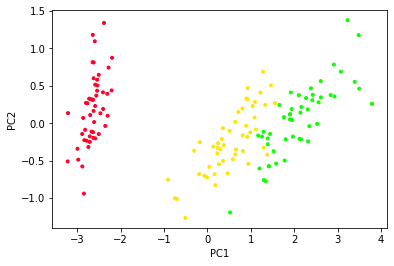

In [3]:
# run PCA
pca_fit = PCA()
pca_fit.fit(iris_obs)
pc_iris_obs = pca_fit.transform(iris_obs)

# plot
cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(30)]

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
utils_lib.plot_clusters(pc_iris_obs[:, 0], pc_iris_obs[:, 1], iris_species, colors1, fig)
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')


# Set up model

In [4]:
# Get priors
prior_params_dict, prior_params_paragami = gmm_lib.get_default_prior_params(dim)

# set initial alpha
alpha0 = 6.0
prior_params_dict['dp_prior_alpha'] = alpha0
print(prior_params_dict)

{'dp_prior_alpha': 6.0, 'prior_centroid_mean': DeviceArray([0.], dtype=float64), 'prior_lambda': DeviceArray([1.], dtype=float64), 'prior_wishart_df': DeviceArray([10.], dtype=float64), 'prior_wishart_rate': DeviceArray([[1., 0., 0., 0.],
             [0., 1., 0., 0.],
             [0., 0., 1., 0.],
             [0., 0., 0., 1.]], dtype=float64)}


## Variational parameters

In [5]:
# number of clusters in variational distribution 
k_approx = 15

In [6]:
# Gauss-Hermite points for integrating logitnormal stick-breaking prior
gh_deg = 8
gh_loc, gh_weights = hermgauss(gh_deg)

# convert to jax arrays
gh_loc, gh_weights = np.array(gh_loc), np.array(gh_weights)

In [7]:
# get vb parameters
vb_params_dict, vb_params_paragami = gmm_lib.get_vb_params_paragami_object(dim, k_approx)

In [8]:
# the objective 
gmm_lib.get_kl(iris_obs, vb_params_dict, prior_params_dict, gh_loc, gh_weights)

DeviceArray(1668.94220611, dtype=float64)

# Optimize

In [9]:
use_presaved_fit = True

In [10]:
if use_presaved_fit: 
    vb_opt_dict, _, meta_data = paragami.load_folded('./initial_fit.npz')

    kl = gmm_lib.get_kl(iris_obs, vb_opt_dict, prior_params_dict, gh_loc, gh_weights)
    
    # chec kmodel matches 
    assert meta_data['alpha0'] == alpha0
    assert np.abs(meta_data['final_kl'] - kl) < 1e-12
    
    # get other parameters
    vb_opt = vb_params_paragami.flatten(vb_opt_dict, free = True)
    e_z_opt = gmm_posterior_quantities_lib.get_optimal_z_from_vb_dict(iris_obs,
                               vb_opt_dict,
                               gh_loc,
                               gh_weights,
                               use_bnp_prior = True)
else: 
    
    # run k-means init 
    n_kmeans_init = 10
    init_vb_free_params, init_vb_params_dict, init_ez = \
        gmm_optim_lib.cluster_and_get_k_means_inits(iris_obs,
                                                vb_params_paragami, 
                                                n_kmeans_init = n_kmeans_init, 
                                                seed = 789970)

    # then optimize 
    vb_opt_dict, vb_opt, e_z_opt, _, _ = \
        gmm_optim_lib.optimize_gmm(iris_obs,
                                     init_vb_params_dict,
                                     vb_params_paragami,
                                     prior_params_dict, 
                                     gh_loc, gh_weights, 
                                     run_newton = True)

### Check results

In [11]:
def plot_results_from_vb_params_dict(pca_fit, vb_params_dict, e_z, fig): 
    # we plot in PCA space
    bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, vb_params_dict['cluster_params']['centroids'], 
                                               np.linalg.inv(vb_params_dict['cluster_params']['cluster_info']))
    
    bnp_clusters = np.argmax(e_z, axis = 1)
    
    cmap = cm.get_cmap(name='gist_rainbow')
    colors1 = [cmap(k * 50) for k in range(30)]
    
    utils_lib.plot_clusters(pc_iris_obs[:, 0], pc_iris_obs[:, 1], bnp_clusters, \
                  colors1, fig, \
                  centroids = bnp_centroids_pc[np.unique(bnp_clusters), :], 
                cov = bnp_cluster_covs_pc[np.unique(bnp_clusters), :, :])


### Plot centroids

Text(0, 0.5, 'PC2')

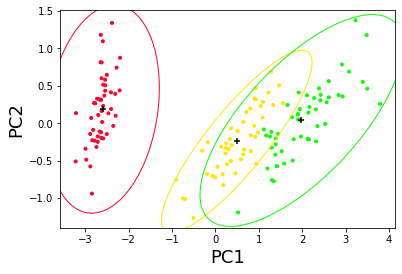

In [12]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(pca_fit, vb_opt_dict, e_z_opt, fig)
fig.set_xlabel('PC1', fontsize = 18)
fig.set_ylabel('PC2', fontsize = 18)


# Define sensitivity class

In [13]:
def objective_fun(vb_params_free, epsilon): 

    # NOTE! epsilon doesn't actual enter 
    # into this function. 

    # since the initial fit is at epsilon = 0, 
    # we just return the actual KL

    # we really just need the hessian wrt to vb free parameters ... 

    vb_params_dict = vb_params_paragami.fold(vb_params_free, 
                                             free = True)

    return gmm_lib.get_kl(iris_obs, 
                          vb_params_dict,
                          prior_params_dict,
                          gh_loc,
                          gh_weights).squeeze()

In [14]:
vb_sens = HyperparameterSensitivityLinearApproximation(objective_fun,
                                                    vb_opt,
                                                    hyper_par_value0 = 0., 
                                                    # this is null for now. 
                                                    # will set appropriately later
                                                    hyper_par_objective_fun = lambda x, y : 0.)

Compiling hessian solver ...
Hessian solver compile time: 58.1287sec

Compiling cross hessian...
Cross-hessian compile time: 0.0506186sec

LR sensitivity time: 0.0196924sec



# Compute influence function


In [15]:
# this contains methods to compute the influence function
influence_operator = influence_lib.InfluenceOperator(vb_opt, 
                                                     vb_params_paragami, 
                                                     vb_sens.hessian_solver,
                                                     prior_params_dict['dp_prior_alpha'],
                                                     stick_key = 'stick_params')

### Define the posterior statistic

In [16]:
prng_key = jax.random.PRNGKey(223)

def _g(vb_free):
    
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    return gmm_posterior_quantities_lib.get_e_num_clusters_from_vb_dict(iris_obs,
                                                    vb_params_dict,
                                                    gh_loc, gh_weights,
                                                    threshold = 0,
                                                    n_samples = 10000, 
                                                    prng_key = prng_key)

g = jax.jit(_g)

### Get gradient of posterior statistic

In [17]:
# get gradient of g and compile
get_grad_g = jax.jit(jax.jacobian(_g, argnums = 0))
_ = get_grad_g(vb_opt).block_until_ready()

In [18]:
# check the timing
%timeit _ = get_grad_g(vb_opt).block_until_ready()

849 µs ± 22.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [19]:
grad_g = get_grad_g(vb_opt)

### Finally, invert the hessian and compute the influence

In [20]:
logit_v_grid = np.linspace(-8, 8, 500)

In [21]:
# the influence function as defined
influence_grid, grad_g_hess_inv = \
            influence_operator.get_influence(logit_v_grid, grad_g)


# this is influence times the prior
influence_grid_x_prior, _ = \
    influence_operator.get_influence(logit_v_grid, 
                                     grad_g, 
                                     normalize_by_prior = False)

In [22]:
# check timing 
%timeit influence_operator.get_influence(logit_v_grid, grad_g)

1.31 s ± 6.57 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# plot the influence

In [23]:
# the prior (for plotting)
def p0(logit_v, alpha0): 
    return np.exp(influence_lib.get_log_logitstick_prior(logit_v, alpha0))

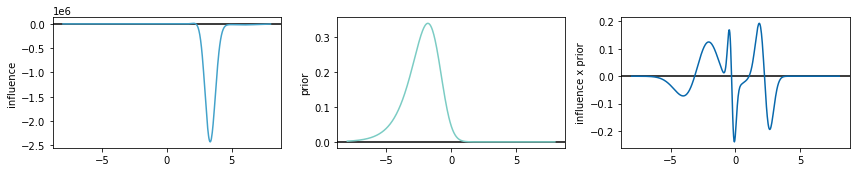

In [24]:
fig, ax = plt.subplots(1, 3, figsize = (12, 2.5),  sharex = True) 

# plot y = 0 line
for i in range(3): 
    ax[i].axhline(0, color = 'black')

# plot influence function
ax[0].plot(logit_v_grid, influence_grid, color = '#43a2ca')

# plot prior
ax[1].plot(logit_v_grid,
           p0(logit_v_grid, alpha0), 
           color = '#7bccc4')

# plot influence x prior
ax[2].plot(logit_v_grid, influence_grid_x_prior, color = '#0868ac')

ax[0].set_ylabel('influence')
ax[1].set_ylabel('prior')
ax[2].set_ylabel('influence x prior')

fig.tight_layout()

# Function to run experiments for different perturbations

In [25]:
def get_lr_derivatives(f_obj, epsilon_vec): 
    # f_obj contains the perturbation
    
    # set derivative 
    vb_sens._set_cross_hess_and_solve(f_obj.hyper_par_objective_fun)
    
    # save lr time
    hess_solve_time = vb_sens.lr_time
    
    # get lr predictions 
    lr_list = []
    lr_time_vec = []

    for epsilon in epsilon_vec: 

        t0 = time.time() 
        # get linear response
        lr_free_params = vb_sens.predict_opt_par_from_hyper_par(np.array([epsilon])).block_until_ready()
        lr_list.append(lr_free_params)

        lr_time_vec.append(time.time() - t0)

    lr_time_vec = onp.array(lr_time_vec)
    
    return lr_list, hess_solve_time, lr_time_vec

In [26]:
def get_refit_results(f_obj, epsilon_vec): 
    
    # f_obj contains the perturbation 
    
    # this function refits 
    # refits for all epsilon in epsilon_vec
    
    # define objective 
    def _f(vb_free, epsilon): 
        
        vb_params_dict = vb_params_paragami.fold(vb_free, 
                                                 free = True)

        return gmm_lib.get_kl(iris_obs, 
                              vb_params_dict,
                              prior_params_dict,
                              gh_loc, gh_weights, 
                              e_log_phi = lambda x, y : f_obj.e_log_phi_epsilon(x, y, epsilon))
    
    
    # jit functions and gradients
    f = jax.jit(_f)
    get_grad = jax.jit(jax.grad(_f, 0))
    
    def _get_hvp(x, epsilon, v):
        return jax.jvp(jax.grad(_f, argnums = 0), (x, epsilon), (v, 0.))[1]

    get_hvp = jax.jit(_get_hvp)
    
    # optimize
    vb_refit_list = []
    refit_time_vec = []
    for epsilon in epsilon_vec: 
        print('\n################')
        print('re-optimzing with epsilon = ', epsilon)
        print('################')

        _, vb_opt_pert, _, refit_time = \
            optimize_kl(lambda x : f(x, epsilon),
                         deepcopy(vb_opt_dict), 
                         vb_params_paragami, 
                         get_grad = lambda x : get_grad(x, epsilon),
                         get_hvp = lambda x, v: get_hvp(x, epsilon, v),
                         run_lbfgs = False,
                         run_newton = True)                          
        
        vb_refit_list.append(vb_opt_pert)
        refit_time_vec.append(refit_time)
        
    return vb_refit_list, refit_time_vec

In [123]:
def run_analysis(f_obj):    
    
    epsilon_vec = np.linspace(0, 1, 6)
    
    ###################
    # get refit results
    ###################
    vb_refit_list, refit_time_vec = get_refit_results(f_obj, epsilon_vec)
    
    # get posterior statistic
    refit_g_vec = result_loading_utils.get_post_stat_vec(g, vb_refit_list)
    

    ###################
    # get lr results
    ###################
    lr_list, hess_solve_time, lr_time_vec = get_lr_derivatives(f_obj, epsilon_vec)
    
    # get posterior statistic
    lr_g_vec = result_loading_utils.get_post_stat_vec(g, lr_list)
    
    return refit_g_vec, lr_g_vec, epsilon_vec

In [42]:
def plot_results(refit_g_vec, lr_g_vec, epsilon_vec, f_obj): 
    
    ###################
    # plot prior x influence function 
    ###################
    fig, ax = plt.subplots(1, 4, figsize = (14, 3.5))
    
    # scale influence so it has l-inf norm 1
    infl_norm = np.abs(influence_grid_x_prior).max()
    scale = np.abs(f_obj.log_phi(logit_v_grid)).max() / infl_norm
    
    ax[0].plot(logit_v_grid, influence_grid_x_prior * scale)
    # plot y = 0
    ax[0].axhline(0, color = 'black')

    # overlay bump
    ax[0].plot(logit_v_grid, 
               f_obj.log_phi(logit_v_grid),
               color = 'grey')

    ax[0].fill_between(logit_v_grid, 
                       0,
                       f_obj.log_phi(logit_v_grid),
                       color = 'grey',
                       alpha = 0.5)
    ax[0].set_xlabel('influence x prior')

    ###################
    # plot perturbed prior 
    ###################
    # compute perturbed prior
    prior_perturbation = func_sens_lib.PriorPerturbation(
                                alpha0 = alpha0,
                                log_phi = f_obj.log_phi, 
                                logit_v_ub = 10, 
                                logit_v_lb = -10)

    prior_perturbation._plot_priors(ax[1])
    prior_perturbation._plot_priors_constrained(ax[2])
    ax[2].legend()

    for j in range(3): 
        ax[j].set_xlabel('logit-sticks')

    ###################
    # plot posterior statistic 
    ###################                        
    # plot refit results
    ax[3].plot(epsilon_vec,
                  refit_g_vec - refit_g_vec[0], 
                  '-o', 
                  label = 'refit')

    # plot lr results
    ax[3].plot(epsilon_vec, 
                  lr_g_vec - lr_g_vec[0], 
                  '-o', 
                  label = 'lr')

    ax[3].set_xlabel('epsilon')
    ax[3].axhline(0, color = 'black')

    ax[3].legend()
    ax[3].set_ylabel('g(pert) - g(init)')

    fig.tight_layout()

In [43]:
def run_all(f_obj): 
    refit_g_vec, lr_g_vec, epsilon_vec = run_analysis(f_obj)
    plot_results(refit_g_vec, lr_g_vec, epsilon_vec, f_obj)

# Get results!

### Worst-case perturbation

In [44]:
worst_case = influence_lib.WorstCasePerturbation(influence_fun = None, 
                                                    logit_v_grid = logit_v_grid, 
                                                    delta = 1.,
                                                    cached_influence_grid = influence_grid)

f_obj_wc = func_sens_lib.FunctionalPerturbationObjective(worst_case.log_phi, 
                                                          vb_params_paragami, 
                                                          e_log_phi = lambda x,y : worst_case.get_e_log_linf_perturbation(x,y), 
                                                          gh_loc = gh_loc, 
                                                          gh_weights = gh_weights, 
                                                          stick_key = 'stick_params')


################
re-optimzing with epsilon =  0.0
################
compiling objective and derivatives ... 
done. Compile time: 23.951sec
Running trust-ncg ... 
Newton time: 0.003sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimzing with epsilon =  0.1
################
compiling objective and derivatives ... 
done. Compile time: 1.445sec
Running trust-ncg ... 
Newton time: 0.232sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimzing with epsilon =  0.2
################
compiling objective and derivatives ... 
done. Compile time: 1.435sec
Running trust-ncg ... 
Newton time: 0.279sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimzing with epsilon =  0.3
################
compiling objective and derivatives ... 
done. Compile time: 1.429sec
Running trust-ncg ... 
Newton time: 0.254sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimzing with

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 3.170746e-02
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.034908e-01
  warnings.warn(


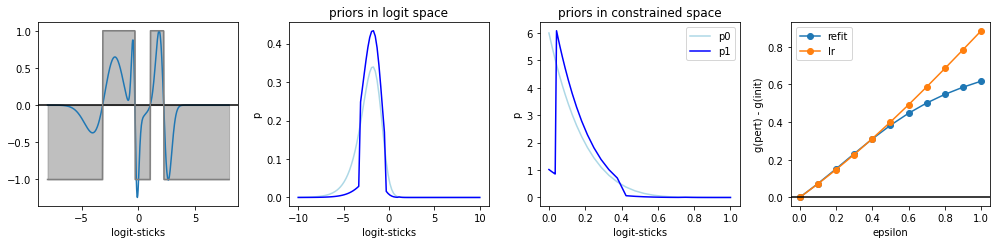

In [45]:
run_all(f_obj_wc)

In [95]:
def gaussian_pert(x, loc, scale): 
    return sp.stats.norm.pdf(x, loc, scale) * np.sqrt(2 * np.pi) * scale


################
re-optimzing with epsilon =  0.0
################
compiling objective and derivatives ... 
done. Compile time: 23.950sec
Running trust-ncg ... 
Newton time: 0.002sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimzing with epsilon =  0.1
################
compiling objective and derivatives ... 
done. Compile time: 1.334sec
Running trust-ncg ... 
Newton time: 0.247sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimzing with epsilon =  0.2
################
compiling objective and derivatives ... 
done. Compile time: 1.330sec
Running trust-ncg ... 
Newton time: 0.200sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimzing with epsilon =  0.3
################
compiling objective and derivatives ... 
done. Compile time: 1.331sec
Running trust-ncg ... 
Newton time: 0.228sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimzing with

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 3.227957e-03
  warnings.warn(


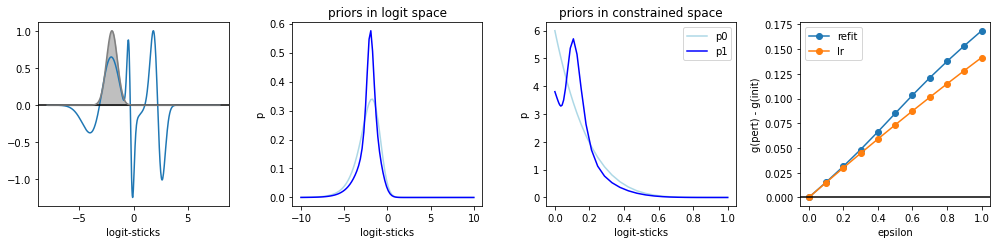

In [96]:
log_phi_gauss1 = lambda x : gaussian_pert(x, loc = -2, scale = 0.5)

f_obj_gauss1 = func_sens_lib.FunctionalPerturbationObjective(log_phi_gauss1, 
                                                          vb_params_paragami, 
                                                          gh_loc = gh_loc, 
                                                          gh_weights = gh_weights, 
                                                          stick_key = 'stick_params')

run_all(f_obj_gauss1)

In [ ]:
log_phi_gauss2 = lambda x : gaussian_pert(x, loc = -4, scale = 0.5)

f_obj_gauss2 = func_sens_lib.FunctionalPerturbationObjective(log_phi_gauss2, 
                                                          vb_params_paragami, 
                                                          gh_loc = gh_loc, 
                                                          gh_weights = gh_weights, 
                                                          stick_key = 'stick_params')

run_all(f_obj_gauss2)


################
re-optimzing with epsilon =  0.0
################
compiling objective and derivatives ... 


In [125]:
# log_phi_gauss3 = lambda x : gaussian_pert(x, loc = -3., scale = 0.5)

# f_obj_gauss3 = func_sens_lib.FunctionalPerturbationObjective(log_phi_gauss3, 
#                                                           vb_params_paragami, 
#                                                           gh_loc = gh_loc, 
#                                                           gh_weights = gh_weights, 
#                                                           stick_key = 'stick_params')

# run_all(f_obj_gauss3)

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.529903e-06
  warnings.warn(


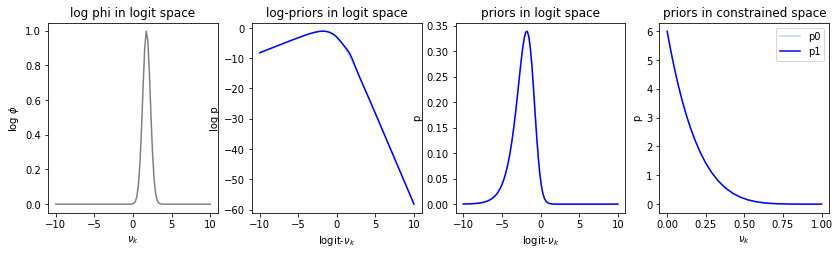

In [120]:
def gaussian_pert(x, loc, scale): 
    return sp.stats.norm.pdf(x, loc, scale) * np.sqrt(2 * np.pi) * scale

log_phi = lambda x : gaussian_pert(x, loc = 1.75, scale = 0.5)

prior_perturbation = func_sens_lib.PriorPerturbation(
                                alpha0 = alpha0,
                                log_phi = log_phi, 
                                logit_v_ub = 10, 
                                logit_v_lb = -10)

prior_perturbation.plot_perturbation()

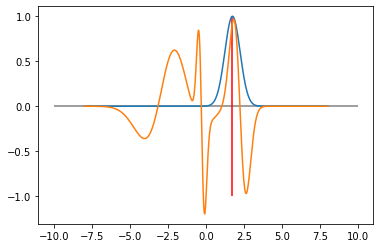

In [121]:
plt.plot(logit_v_grid, log_phi(logit_v_grid))
plt.plot(logit_v_grid, influence_grid_x_prior * 5)

plt.hlines(y = 0, xmin = -10, xmax = 10, color = 'grey')

plt.vlines(x=1.75, ymin = -1, ymax = 1, color = 'red')
# plt.vlines(x=-2, ymin = -1, ymax = 1, color = 'red')
# plt.vlines(x=-3,ymin = -1, ymax = 1, color = 'red')

In [103]:
# log_phi = lambda x : gaussian_pert(x, loc = -4, scale = 0.5)

# prior_perturbation = func_sens_lib.PriorPerturbation(
#                                 alpha0 = alpha0,
#                                 log_phi = log_phi, 
#                                 logit_v_ub = 10, 
#                                 logit_v_lb = -10)

# prior_perturbation.plot_perturbation()

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 7.412626e-07
  warnings.warn(


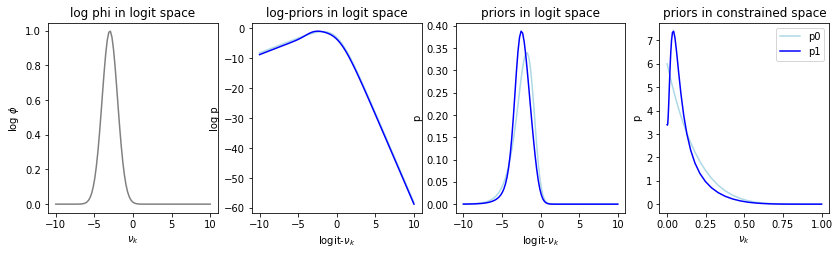

In [90]:
log_phi = lambda x : gaussian_pert(x, loc = -3, scale = 1)

prior_perturbation = func_sens_lib.PriorPerturbation(
                                alpha0 = alpha0,
                                log_phi = log_phi, 
                                logit_v_ub = 10, 
                                logit_v_lb = -10)

prior_perturbation.plot_perturbation()

In [91]:
worst_case.change_points

DeviceArray([-3.15831663, -0.30460922,  1.04208417,  2.22845691], dtype=float64)

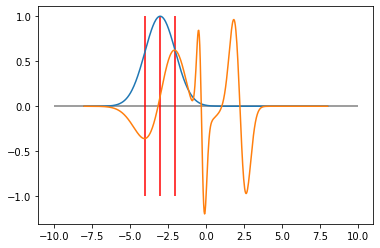

In [92]:
plt.plot(logit_v_grid, log_phi(logit_v_grid))
plt.plot(logit_v_grid, influence_grid_x_prior * 5)
plt.hlines(y = 0, xmin = -10, xmax = 10, color = 'grey')
plt.vlines(x=-4, ymin = -1, ymax = 1, color = 'red')
plt.vlines(x=-2, ymin = -1, ymax = 1, color = 'red')
plt.vlines(x=-3,ymin = -1, ymax = 1, color = 'red')